In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cross_validation
from scipy.stats import multivariate_normal
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold

/Users/maxsimon/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits = load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [4]:
# use only 1 and 7 for this exercise
mask_all = np.logical_or(target == 1, target == 7)
X_all = data[mask_all]
y_all = target[mask_all]

In [5]:
# create a kfold instance (for the performance measurements)
kf = KFold(n_splits=10)

# Question 1: Dimension reduction

In [6]:
def get_class(x, y, desired):
    """
    Returns a subarray of x where y = desired
    """
    return x[y == desired]

First of all we are looking onto the difference of a mean image of all 1's and a mean image of all 7's.

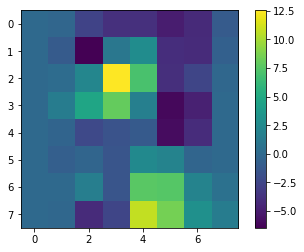

In [9]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(np.mean(get_class(images, target, 1), axis=0) - np.mean(get_class(images, target, 7), axis=0))
plt.colorbar(im)
plt.show()

One can recognize, that pixels (2,3), (2,4), (3,3) as well as pixels (6,4), (6,5), (7,4), (7,5) are often populated in a 1 whereas pixels (1,2), (3,5), (4,5) and (7,2) are often populated in a 7.

In [8]:
pixels_1 = [(2,3,3), (2,4,.5), (3,3,.5), (6,4,0.5), (6,5,0.5)]
pixels_7 = [(1,2,1.5), (3,5,1.5), (4,5,1), (0,5,0.5)]

def flat_ind(index):
    return np.ravel_multi_index(index, (8, 8))

def reduce_dim(x):
    reduced = np.empty((x.shape[0], 2))
    # first feature is large for a digit 1
    reduced[:,0] = np.sum([pixel[2]*x[:,flat_ind(pixel[:2])] for pixel in pixels_1], axis=0)
    # second feature is large for a digit 7
    reduced[:,1] = np.sum([pixel[2]*x[:,flat_ind(pixel[:2])] for pixel in pixels_7], axis=0)
    return reduced

## Validation of feature choice

In [9]:
X_all_r = reduce_dim(X_all)

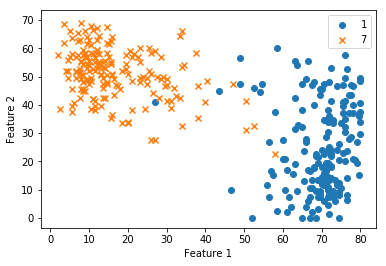

In [10]:
fig, ax = plt.subplots(1, 1)
# plot the 1's
ax.scatter(get_class(X_all_r, y_all, 1)[:,0], get_class(X_all_r, y_all, 1)[:,1], marker='o', label="1")
# plot the 7's
ax.scatter(get_class(X_all_r, y_all, 7)[:,0], get_class(X_all_r, y_all, 7)[:,1], marker='x', label="7")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()
plt.show()

Not to good, as required :D

# Question 2: Nearest Mean Classifier

In [11]:
def nearest_mean(training_features, training_labels, test_features):
    """
    This function implements the nearest mean classifier
    """
    # calculating the mean of feature 1 and feature 2 for the training set of digit 1
    mean_1 = np.mean(get_class(training_features, training_labels, 1), axis = 0)
    # calculating the mean of feature 1 and feature 2 for the training set of digit 7
    mean_7 = np.mean(get_class(training_features, training_labels, 7), axis = 0)
    
    # create distance matrix
    distances = np.empty_like(test_features)
    
    distances[:,0] = np.sqrt(np.sum([(test_features[:,i] - mean_1[i])**2 for i in range(2)], axis=0)) # distance to cluster 1
    distances[:,1] = np.sqrt(np.sum([(test_features[:,i] - mean_7[i])**2 for i in range(2)], axis=0)) # distance to cluster 7
    
    # create prediction
    prediction = np.empty((test_features.shape[0]), dtype=float)
    prediction[:] = 1 # set all to label 1
    # if distance to 7 is smaller: set to label 7
    prediction[distances[:,0] > distances[:,1]] = 7
    
    return prediction

## Visualisation of decision regions

For this exercise we need a training and a test set. However, the performance measurement is done with cross validation.

In [12]:
X_train_r , X_test_r , y_train , y_test = cross_validation.train_test_split(X_all_r, y_all, test_size=0.4, random_state=0)

In [13]:
# create a grid for decision regions
grid_feat_1 = np.linspace(np.min(X_all_r[:,0]), np.max(X_all_r[:,0]), 300)
grid_feat_2 = np.linspace(np.min(X_all_r[:,1]), np.max(X_all_r[:,1]), 300)

# thanks to SO, this has suitable dimensions for the algos
grid = np.transpose([np.tile(grid_feat_1, len(grid_feat_2)), np.repeat(grid_feat_2, len(grid_feat_1))])
# this has suitable dimensions for plotting contours
mesh_feat1, mesh_feat2 = np.meshgrid(grid_feat_1, grid_feat_2)

In [14]:
# apply classifier
grid_pred_nm = nearest_mean(X_train_r, y_train, grid)
test_pred_nm = nearest_mean(X_train_r, y_train, X_test_r)

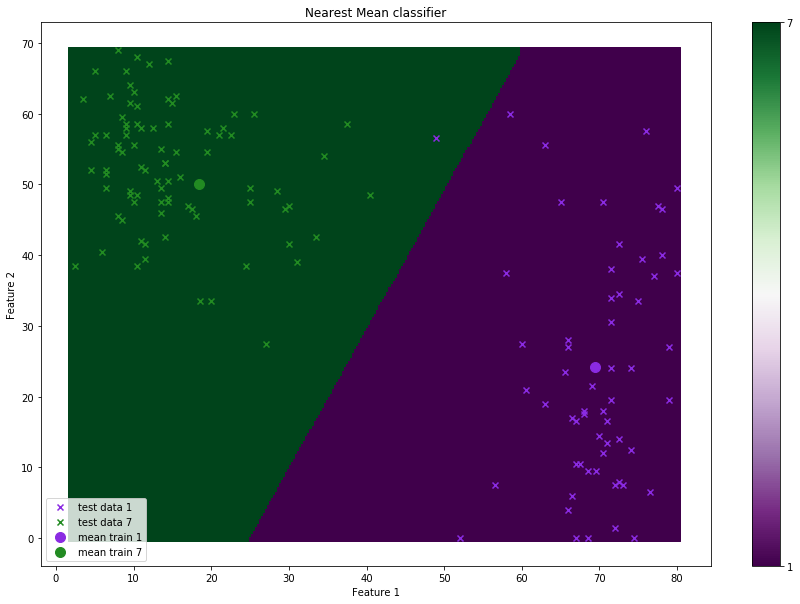

In [33]:
# plot that stuff

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# plot the decision region
scat = ax.scatter(grid[:,0], grid[:,1], c=grid_pred_nm, marker='s', cmap='PRGn')
cbar = plt.colorbar(scat, ticks=[1, 7])
# plot the test data
ax.scatter(get_class(X_test_r, y_test, 1)[:,0], get_class(X_test_r, y_test, 1)[:,1], marker='x', color='blueviolet', label="test data 1")
ax.scatter(get_class(X_test_r, y_test, 7)[:,0], get_class(X_test_r, y_test, 7)[:,1], marker='x', color='forestgreen', label="test data 7")
# plot the means for 1 and 7, yeah well nice implementation of the mean :D
ax.scatter(*np.mean(get_class(X_train_r, y_train, 1), axis = 0), marker='o', color='blueviolet', s=100, label="mean train 1")
ax.scatter(*np.mean(get_class(X_train_r, y_train, 7), axis = 0), marker='o', color='forestgreen', s=100, label="mean train 7")
# labelling
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Nearest Mean classifier')
ax.legend(loc=3)
plt.show()

In [16]:
# Performance measurement
error_rates_nm = []
for train, test in kf.split(X_all_r):
    # prediction
    pred_fold_nm = nearest_mean(X_all_r[train], y_all[train], X_all_r[test])
    # calculation of error
    error_rates_nm.append(np.count_nonzero(pred_fold_nm - y_all[test])/pred_fold_nm.shape[0])
    
mean_error_nm = np.mean(error_rates_nm)
std_error_nm = np.std(error_rates_nm)

print('Mean error rate on 10 folds: {:f} (std: {:f})'.format(mean_error_nm, std_error_nm))
print('This corresponds to {:f} wrong classifications'.format(mean_error_nm*len(test)))

Mean error rate on 10 folds: 0.019444 (std: 0.032984)
This corresponds to 0.700000 wrong classifications


# Question 3: QDA

## Implementation of fitting

In [34]:
def fit_qda(training_features, training_labels, possible_features=[1, 7]):
    D = training_features.shape[1] # dimension of features
    F = len(possible_features) # number of features we are dealing with
    
    # create an array of testsetdata
    ts = [get_class(training_features, training_labels, feature) for feature in possible_features]
    # caculate the total amount of testdata (including all possible features)
    N_tot = sum([tsf.shape[0] for tsf in ts])

    # mu has the shape FxD
    mu = np.empty((F, D), dtype=float)
    # cov should have the shape FxDxD
    cov = np.empty((F, D, D))
    # the priors are scalars and have therefore the shape F
    p = np.empty(F)
    
    for i in range(F):
        N = ts[i].shape[0] # number of training instances for the feature possible_feature[i]
        # calculating mu
        mu[i] = np.mean(ts[i], axis=0)
    
        # calculating the covariance matrix
        ts_centralised = ts[i] - mu[i]
        # some numpy magic
        cov[i] = np.add.reduce(ts_centralised[:,:,np.newaxis] * ts_centralised[:,np.newaxis,:])/N
    
        # calculating the priors
        p[i] = N/N_tot
        
    # done
    return mu, cov, p


## Prediction

In [35]:
def predict_qda(mu, covmat, p, test_features, possible_features = [1, 7]):
    # numpy array to store the results for each k
    results = np.empty((len(possible_features), test_features.shape[0]))
    
    # for each class
    for i in range(len(possible_features)):
        # calculating b_k
        bk = np.log(np.linalg.det(covmat[i])) - 2*np.log(p[i])
        
        # calculating the inverse of the cov-matrix
        sig_inv = np.linalg.inv(covmat[i])
        # centralise the coordinates
        centralised = test_features - mu[i]
        # calculate the Mohalunsbis-distance with some numpy magic
        moha_dist = np.sum(centralised * np.tensordot(sig_inv, centralised, (1, 1)).T, axis=1)
        # store the result
        results[i] = moha_dist + bk
    
    # minimize the results
    minimized = np.argmin(results, axis = 0)
    
    # this will hold the predicted label instead of its index in possible_features
    test_labels = np.empty(test_features.shape[0])
    # populate this stuff
    for i, k in enumerate(possible_features):
        test_labels[minimized == i] = k
    
    return test_labels

### Fitting with training data 

I guess we are supposed to train with the complete data set since we are applying crossvalidation later.

In [19]:
mu_qda, cov_qda, p_qda = fit_qda(X_all_r, y_all)

In [20]:
# apply to test set, training set and grid
grid_pred_qda = predict_qda(mu_qda, cov_qda, p_qda, grid)
train_pred_qda = predict_qda(mu_qda, cov_qda, p_qda, X_all_r)

## Visualisation

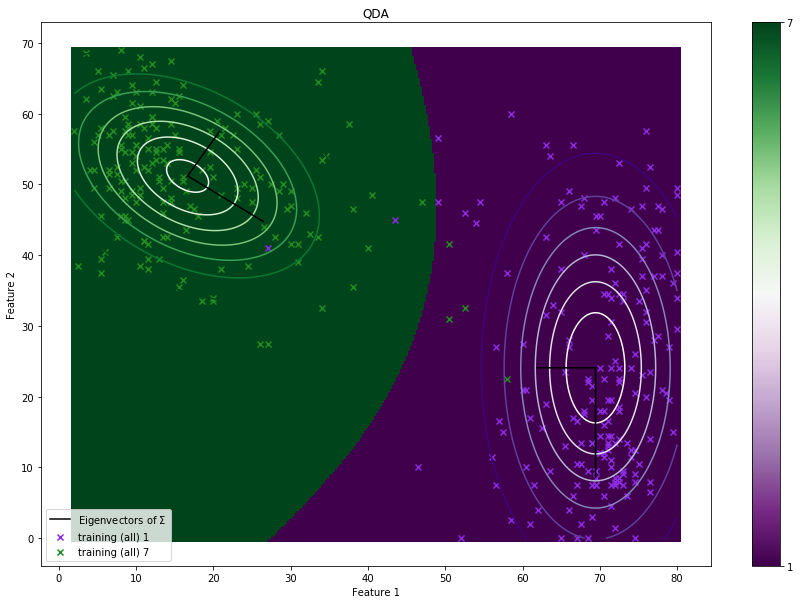

In [21]:
# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot the decision region
scat = ax.scatter(grid[:,0], grid[:,1], c=grid_pred_qda, marker='s', cmap='PRGn')
cbar = plt.colorbar(scat, ticks=[1, 7])
# plot the training
ax.scatter(get_class(X_all_r, y_all, 1)[:,0], get_class(X_all_r, y_all, 1)[:,1], marker='x', color='blueviolet', label="training (all) 1")
ax.scatter(get_class(X_all_r, y_all, 7)[:,0], get_class(X_all_r, y_all, 7)[:,1], marker='x', color='forestgreen', label="training (all) 7")

#plot the gaussians
gauss_1_qda = multivariate_normal.pdf(grid, mean=mu_qda[0], cov=cov_qda[0])
gauss_2_qda = multivariate_normal.pdf(grid, mean=mu_qda[1], cov=cov_qda[1])
cg1 = ax.contour(mesh_feat1, mesh_feat2, gauss_1_qda.reshape(300, 300), cmap='Purples_r')
cg2 = ax.contour(mesh_feat1, mesh_feat2, gauss_2_qda.reshape(300, 300), cmap='Greens_r')

# eigenvalue decomposition
e_val_1, e_vec_1 = np.linalg.eig(cov_qda[0])
e_val_2, e_vec_2 = np.linalg.eig(cov_qda[1])
# for label 1
ax.plot([mu_qda[0, 0], mu_qda[0, 0] + np.sqrt(e_val_1[0])*e_vec_1[0, 0]], [mu_qda[0, 1], mu_qda[0, 1] + np.sqrt(e_val_1[0])*e_vec_1[1, 0]], color='k', label='Eigenvectors of $\Sigma$')
ax.plot([mu_qda[0, 0], mu_qda[0, 0] + np.sqrt(e_val_1[1])*e_vec_1[0, 1]], [mu_qda[0, 1], mu_qda[0, 1] + np.sqrt(e_val_1[1])*e_vec_1[1, 1]], color='k')
# for label 7
ax.plot([mu_qda[1, 0], mu_qda[1, 0] + np.sqrt(e_val_2[0])*e_vec_2[0, 0]], [mu_qda[1, 1], mu_qda[1, 1] + np.sqrt(e_val_2[0])*e_vec_2[1, 0]], color='k')
ax.plot([mu_qda[1, 0], mu_qda[1, 0] + np.sqrt(e_val_2[1])*e_vec_2[0, 1]], [mu_qda[1, 1], mu_qda[1, 1] + np.sqrt(e_val_2[1])*e_vec_2[1, 1]], color='k')

# labelling
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('QDA')
ax.legend(loc=3)
plt.show()

There are some missclassifications. We can find 4 instances of 7 inside the decision area of 1 and 2 instances of 1 inside the decision area for 7. There are 182 training instances for label 1 and 179 training instances for label 7. Therefore the training error is $\approx \frac{6}{179 + 182} = 1.7\%$.
In comparison to the Nearest Neighbour classifier, QDA does not use the training instances directly for classification, but the fitted Gaussian. Therefore outlayers of the cluster can be misclassified.

## Performance measure

In [22]:
error_rates_qda = []
for train, test in kf.split(X_all_r):
    # fitting
    mu_fold_qda, cov_fold_qda, p_fold_qda = fit_qda(X_all_r[train], y_all[train])
    # prediction
    pred_fold_qda = predict_qda(mu_fold_qda, cov_fold_qda, p_fold_qda, X_all_r[test])
    # calculation of error
    error_rates_qda.append(np.count_nonzero(pred_fold_qda - y_all[test])/pred_fold_qda.shape[0])
    
mean_error_qda = np.mean(error_rates_qda)
std_error_qda = np.std(error_rates_qda)

print('Mean error rate on 10 folds: {:f} (std: {:f})'.format(mean_error_qda, std_error_qda))
print('This corresponds to {:f} wrong classifications'.format(mean_error_qda*len(test)))

Mean error rate on 10 folds: 0.019444 (std: 0.030556)
This corresponds to 0.700000 wrong classifications


# Question 4: LDA

## Implementation of Fitting

In [36]:
# mainly copy paste except for calculation of covariance matrix
def fit_lda(training_features, training_labels, possible_features=[1, 7]):
    D = training_features.shape[1] # dimension of features
    F = len(possible_features) # number of features we are dealing with
    
    # create an array of testsetdata
    ts = [get_class(training_features, training_labels, feature) for feature in possible_features]
    # caculate the total amount of testdata (including all possible features)
    N_tot = sum([tsf.shape[0] for tsf in ts])

    # mu has the shape FxD
    mu = np.empty((F, D), dtype=float)
    # cov should have the shape FxDxD
    cov = np.zeros((D, D))
    # the priors are scalars and have therefore the shape F
    p = np.empty(F)
    
    for i in range(F):
        N = ts[i].shape[0] # number of training instances for the feature possible_feature[i]
        # calculating mu
        mu[i] = np.mean(ts[i], axis=0)
    
        # calculating the covariance matrix
        ts_centralised = ts[i] - mu[i]
        # some numpy magic
        cov += np.add.reduce(ts_centralised[:,:,np.newaxis] * ts_centralised[:,np.newaxis,:])/N
    
        # calculating the priors
        p[i] = N/N_tot
    
    w = 2*np.dot(mu, cov)
    bk = -np.diag(np.tensordot(mu, np.dot(mu, cov), (1, 1))) - np.log(np.linalg.det(cov)) + 2*np.log(p)
    
    # done
    return w, bk, mu, cov # mu and cov just need for plotting


## Prediction

In [37]:
def predict_lda(w, bk, test_features, possible_features = [1, 7]):
    # numpy array to store the results for each k
    results = np.empty((len(possible_features), test_features.shape[0]))
    
    # for each class
    for i in range(len(possible_features)):
        # store the result
        results[i] = np.dot(test_features, w[i]) + bk[i]
    
    # maximize the results
    maximize = np.argmax(results, axis = 0)
    
    # this will hold the predicted label instead of its index in possible_features
    test_labels = np.empty(test_features.shape[0])
    # populate this stuff
    for i, k in enumerate(possible_features):
        test_labels[maximize == i] = k
    
    return test_labels

### Fitting with training data

In [38]:
w_lda, bk_lda, mu_lda, cov_lda = fit_lda(X_all_r, y_all)

In [39]:
# apply to test set, training set and grid
grid_pred_lda = predict_lda(w_lda, bk_lda, grid)
train_pred_lda = predict_lda(w_lda, bk_lda, X_all_r)

## Visualisation

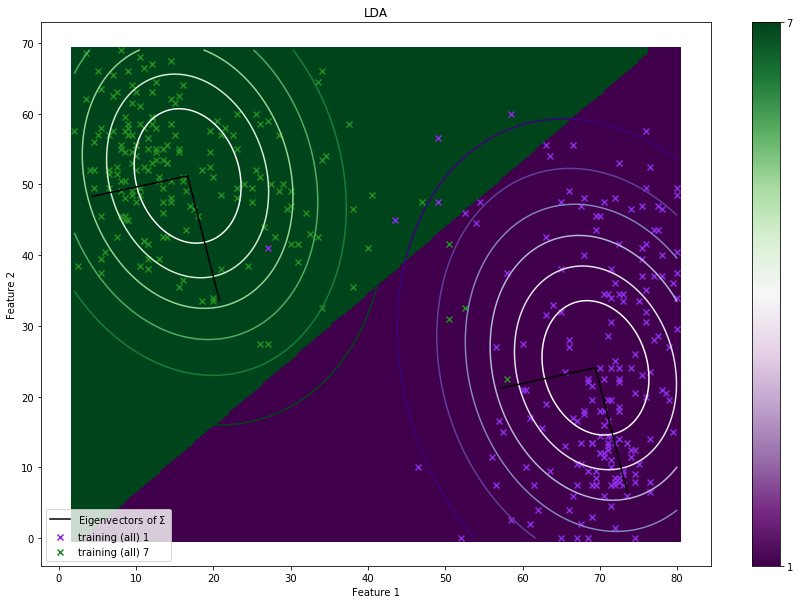

In [40]:
# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot the decision region
scat = ax.scatter(grid[:,0], grid[:,1], c=grid_pred_lda, marker='s', cmap='PRGn')
cbar = plt.colorbar(scat, ticks=[1, 7])
# plot the training
ax.scatter(get_class(X_all_r, y_all, 1)[:,0], get_class(X_all_r, y_all, 1)[:,1], marker='x', color='blueviolet', label="training (all) 1")
ax.scatter(get_class(X_all_r, y_all, 7)[:,0], get_class(X_all_r, y_all, 7)[:,1], marker='x', color='forestgreen', label="training (all) 7")

#plot the gaussians
gauss_1_lda = multivariate_normal.pdf(grid, mean=mu_lda[0], cov=cov_lda)
gauss_2_lda = multivariate_normal.pdf(grid, mean=mu_lda[1], cov=cov_lda)
cg1 = ax.contour(mesh_feat1, mesh_feat2, gauss_1_lda.reshape(300, 300), cmap='Purples_r')
cg2 = ax.contour(mesh_feat1, mesh_feat2, gauss_2_lda.reshape(300, 300), cmap='Greens_r')

# eigenvalue decomposition
e_val_lda, e_vec_lda = np.linalg.eig(cov_lda)
# for label 1
ax.plot([mu_lda[0, 0], mu_lda[0, 0] + np.sqrt(e_val_lda[0])*e_vec_lda[0, 0]], [mu_lda[0, 1], mu_lda[0, 1] + np.sqrt(e_val_lda[0])*e_vec_lda[1, 0]], color='k', label='Eigenvectors of $\Sigma$')
ax.plot([mu_lda[0, 0], mu_lda[0, 0] + np.sqrt(e_val_lda[1])*e_vec_lda[0, 1]], [mu_lda[0, 1], mu_lda[0, 1] + np.sqrt(e_val_lda[1])*e_vec_lda[1, 1]], color='k')
# for label 7
ax.plot([mu_lda[1, 0], mu_lda[1, 0] + np.sqrt(e_val_lda[0])*e_vec_lda[0, 0]], [mu_lda[1, 1], mu_lda[1, 1] + np.sqrt(e_val_lda[0])*e_vec_lda[1, 0]], color='k')
ax.plot([mu_lda[1, 0], mu_lda[1, 0] + np.sqrt(e_val_lda[1])*e_vec_lda[0, 1]], [mu_lda[1, 1], mu_lda[1, 1] + np.sqrt(e_val_lda[1])*e_vec_lda[1, 1]], color='k')

# labelling
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('LDA')
ax.legend(loc=3)
plt.show()

## Performance measure

In [41]:
error_rates_lda = []
for train, test in kf.split(X_all_r):
    # fitting
    w_fold_lda, bk_fold_lda, _, _ = fit_lda(X_all_r[train], y_all[train])
    # prediction
    pred_fold_lda = predict_lda(w_fold_lda, bk_fold_lda, X_all_r[test])
    # calculation of error
    error_rates_lda.append(np.count_nonzero(pred_fold_lda - y_all[test])/pred_fold_lda.shape[0])
    
mean_error_lda = np.mean(error_rates_lda)
std_error_lda = np.std(error_rates_lda)

print('Mean error rate on 10 folds: {:f} (std: {:f})'.format(mean_error_lda, std_error_lda))
print('This corresponds to {:f} wrong classifications'.format(mean_error_lda*len(test)))

Mean error rate on 10 folds: 0.027778 (std: 0.044790)
This corresponds to 1.000000 wrong classifications


# Comparison

In my case the Nearest Mean Classifier and the QDA perform equally well. The LDA has a slightly larger error rate. However, the digits 1 and 7 are well distinguishable because the selected features differ a lot for the two digits.